In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

In [3]:
import os
import random
import math
import warnings
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.2)

warnings.filterwarnings('ignore')

In [4]:
import optuna
import lightgbm
import xgboost
from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectPercentile, SelectKBest, mutual_info_classif, mutual_info_regression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics.scorer import make_scorer

In [5]:
from tqdm import tqdm
from tqdm.keras import TqdmCallback

In [6]:
from sklearn.datasets import make_classification
import imblearn

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn import over_sampling
from imblearn import combine

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [7]:
colab_drive_path = '/content/drive/MyDrive'
consumer_complaints = pd.read_csv('/content/drive/MyDrive/dataset/consumer_complaints.csv')
df = consumer_complaints.copy()
rename_cols = {'Date received': 'date_received', 'Product':'product', 'Sub-product':'sub_product', 
               'Sub-issue':'sub_issue', 'Consumer complaint narrative': 'complaint', 'Issue':'issue',
               'Company public response': 'response_to_public', 'Company':'company', 'State':'state',
              'ZIP code':'zip', 'Tags':'tags', 'Consumer consent provided?': 'consent_provided',
              'Submitted via': 'submitted_via', 'Date sent to company':'date_sent',
              'Company response to consumer':'response_to_consumer', 'Timely response?':'timely_response',
              'Consumer disputed?':'consumer_disputed', 'Complaint ID':'complaint_id'}
df.rename(columns=rename_cols, inplace=True)

df['date_received'] = pd.to_datetime(df['date_received'], format="%m/%d/%Y")
df['date_sent'] = pd.to_datetime(df['date_sent'], format="%m/%d/%Y")

df.drop('complaint_id', axis=1, inplace=True)
target = 'response_to_consumer'

In [8]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint,response_to_public,company,state,zip,tags,consent_provided,submitted_via,date_sent,response_to_consumer,timely_response,consumer_disputed
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,2013-07-30,Closed with explanation,Yes,No
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,2013-07-31,Closed with explanation,Yes,No
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,2013-07-31,Closed,Yes,No
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,06106,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No


# Some Functions

In [9]:
def get_top_k_frequent_percentage(col, k=10):
    return df[col].value_counts().head(k).sum()*100/df.shape[0]
def get_top_k_frequent_items(col, k=10):
    return set(df[col].value_counts().head(k).index.tolist())

# Fill Null Values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670598 entries, 0 to 670597
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date_received         670598 non-null  datetime64[ns]
 1   product               670598 non-null  object        
 2   sub_product           472396 non-null  object        
 3   issue                 670598 non-null  object        
 4   sub_issue             269868 non-null  object        
 5   complaint             114704 non-null  object        
 6   response_to_public    145197 non-null  object        
 7   company               670598 non-null  object        
 8   state                 665293 non-null  object        
 9   zip                   665274 non-null  object        
 10  tags                  94730 non-null   object        
 11  consent_provided      208151 non-null  object        
 12  submitted_via         670598 non-null  object        
 13 

In [11]:
df['response_to_consumer'].value_counts()

Closed with explanation            493981
Closed with non-monetary relief     84557
Closed with monetary relief         45170
Closed without relief               17863
Closed                              15492
Closed with relief                   5298
In progress                          4665
Untimely response                    3572
Name: response_to_consumer, dtype: int64

In [12]:
s = df.isna().sum() == 0
s[s].index.tolist()

['date_received',
 'product',
 'issue',
 'company',
 'submitted_via',
 'date_sent',
 'response_to_consumer',
 'timely_response']

In [13]:
s = df.isna().sum()*100/df.shape[0] > 0
high_null_col = s[s].index.tolist()
df[high_null_col].isna().sum()*100/df.shape[0]

sub_product           29.556
sub_issue             59.757
complaint             82.895
response_to_public    78.348
state                  0.791
zip                    0.794
tags                  85.874
consent_provided      68.960
consumer_disputed      6.176
dtype: float64

In [14]:
df['timely_response'].value_counts()

Yes    652848
No      17750
Name: timely_response, dtype: int64

In [15]:
df['product'].value_counts()

Mortgage                   210324
Debt collection            124236
Credit reporting           119195
Credit card                 79007
Bank account or service     76084
Consumer Loan               26604
Student loan                21651
Payday loan                  4786
Money transfers              4720
Prepaid card                 3171
Other financial service       806
Virtual currency               14
Name: product, dtype: int64

In [16]:
df['complaint'] = 1 - df['complaint'].isna().astype(int)
df['response_to_public'], index_response_to_public = pd.factorize(df['response_to_public'])
df['tags'], index_tags = pd.factorize(df['tags'])
df['consent_provided'], index_consent_provided = pd.factorize(df['consent_provided'])

In [17]:
# df.groupby('sub_issue')[target].value_counts().to_frame().head(300).head(50)
### checked to make sure that there is no particular relevance of 'sub_issue' to 'response_to_consumer'

In [18]:
sub_issue_top = df['sub_issue'].value_counts().head(6).index.tolist()
df['sub_issue'] = df['sub_issue'].apply(lambda x: 'others' if (not x is np.nan) and (x not in sub_issue_top) else x)
df['sub_issue'], index_sub_issue = pd.factorize(df['sub_issue'])

In [19]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint,response_to_public,company,state,zip,tags,consent_provided,submitted_via,date_sent,response_to_consumer,timely_response,consumer_disputed
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,-1,0,-1,Wells Fargo & Company,VA,24540,-1,-1,Phone,2013-07-30,Closed with explanation,Yes,No
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,-1,0,-1,Wells Fargo & Company,CA,95992,0,-1,Web,2013-07-31,Closed with explanation,Yes,No
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",-1,0,-1,Santander Bank US,NY,10065,-1,-1,Fax,2013-07-31,Closed,Yes,No
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,-1,0,-1,Wells Fargo & Company,GA,30084,-1,-1,Web,2013-07-30,Closed with explanation,Yes,No
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",-1,0,-1,Franklin Credit Management,CT,06106,-1,-1,Web,2013-07-30,Closed with explanation,Yes,No


In [20]:
cols = ['state', 'zip', 'consumer_disputed']
df.loc[:, cols] = df[cols].fillna(method='ffill') # used ffill since % na is less and data is a bit sequential

In [21]:
df['product'].value_counts()

Mortgage                   210324
Debt collection            124236
Credit reporting           119195
Credit card                 79007
Bank account or service     76084
Consumer Loan               26604
Student loan                21651
Payday loan                  4786
Money transfers              4720
Prepaid card                 3171
Other financial service       806
Virtual currency               14
Name: product, dtype: int64

In [22]:
col = 'sub_product'
df_sub_prod_fill = df[~df['sub_product'].isna()].groupby(['product'])[col].apply(lambda x: x.mode().iloc[0]).to_frame().reset_index()
df[df['sub_product'].isna()]['product'].value_counts()

Credit reporting    119195
Credit card          79007
Name: product, dtype: int64

In [23]:
## since only missing values correspond to products 'credit reporting' and 'creadit card', 
## let's fill the 'sub_product' by 'credit'
df['sub_product'].fillna(value='credit', inplace=True)

# Categorical Encoding

In [24]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint,response_to_public,company,state,zip,tags,consent_provided,submitted_via,date_sent,response_to_consumer,timely_response,consumer_disputed
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,-1,0,-1,Wells Fargo & Company,VA,24540,-1,-1,Phone,2013-07-30,Closed with explanation,Yes,No
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,-1,0,-1,Wells Fargo & Company,CA,95992,0,-1,Web,2013-07-31,Closed with explanation,Yes,No
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",-1,0,-1,Santander Bank US,NY,10065,-1,-1,Fax,2013-07-31,Closed,Yes,No
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,-1,0,-1,Wells Fargo & Company,GA,30084,-1,-1,Web,2013-07-30,Closed with explanation,Yes,No
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",-1,0,-1,Franklin Credit Management,CT,06106,-1,-1,Web,2013-07-30,Closed with explanation,Yes,No


In [25]:
yes_no_dct = {'Yes':1, 'No':0}
df['timely_response'] = df['timely_response'].apply(lambda x: yes_no_dct[x])
df['consumer_disputed'] = df['consumer_disputed'].apply(lambda x: yes_no_dct[x])

In [26]:
for col in df.select_dtypes(['object']):
    print(f'{df[col].nunique():>5}, {col}')

   12, product
   48, sub_product
   95, issue
 3933, company
   62, state
27889, zip
    6, submitted_via
    8, response_to_consumer


In [27]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint,response_to_public,company,state,zip,tags,consent_provided,submitted_via,date_sent,response_to_consumer,timely_response,consumer_disputed
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,-1,0,-1,Wells Fargo & Company,VA,24540,-1,-1,Phone,2013-07-30,Closed with explanation,1,0
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,-1,0,-1,Wells Fargo & Company,CA,95992,0,-1,Web,2013-07-31,Closed with explanation,1,0
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",-1,0,-1,Santander Bank US,NY,10065,-1,-1,Fax,2013-07-31,Closed,1,0
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,-1,0,-1,Wells Fargo & Company,GA,30084,-1,-1,Web,2013-07-30,Closed with explanation,1,0
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",-1,0,-1,Franklin Credit Management,CT,06106,-1,-1,Web,2013-07-30,Closed with explanation,1,0


In [28]:
df['time_delta'] = (df['date_sent'] - df['date_received']).dt.days

for col in ['date_received', 'date_sent']:
    df[col+'_day'] = df[col].dt.day
    df[col+'_month'] = df[col].dt.month
    df[col+'_quarter'] = df[col].dt.quarter
    df[col+'_year'] = df[col].dt.year

In [29]:
# def get_zip_val_to_k_place(z):
#     k = 3
#     z = [val for val in str(z)]
#     z[-k:] = ['0']*k
#     return int(''.join(z))

# def try_zip_rounding(z):
#     try:
#         return get_zip_val_to_k_place(z)
#     except:
#         return np.nan

# df['zip_rounded'] = df['zip'].apply(try_zip_rounding)

# func = lambda x: x.fillna(x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0])
# df['zip_rounded'] = df.groupby(['state'])['zip_rounded'].transform(func)
# df['zip_rounded'] = df['zip_rounded'].apply(lambda x: abs(int(x)))

# top_zip_codes = df['zip_rounded'].value_counts().head(35).index.tolist()

After rounding `zip` code to last 3 places, and filling null values using `groupby` and `median`,
we check unique values of `zip` grouping by `state` and find that most of the zip codes are concentrated
on 1-3 zip codes within a state, which is not accounting for much variance given `state` info.
Even if we pick up top few `zip` codes and replace the rest by the median values using groupby on state,
it will not add any info besides what we have from `state` info, but will create many more columns after
one hot encoding. 
Hence, we will drop `zip` feature.

In [30]:
cols_to_drop = ['date_received', 'date_sent', 'zip']
cat_cols = df.select_dtypes(['object', 'datetime64']).columns.tolist()
cat_cols = list(set(cat_cols).difference(set(cols_to_drop)))
print(cat_cols)
for col in cat_cols:
    print(f'{df[col].nunique():>4} {col}')

['state', 'issue', 'submitted_via', 'response_to_consumer', 'sub_product', 'company', 'product']
  62 state
  95 issue
   6 submitted_via
   8 response_to_consumer
  48 sub_product
3933 company
  12 product


In [31]:
print('product top freq percentage: ', get_top_k_frequent_percentage('product', 8))
print('sub_product top freq percentage: ', get_top_k_frequent_percentage('sub_product', 8))
print('issue top freq percentage: ', get_top_k_frequent_percentage('issue', 8))
print('state top freq percentage: ', get_top_k_frequent_percentage('state', 15))
print('company top freq percentage: ', get_top_k_frequent_percentage('company', 15))

product top freq percentage:  98.70101014318564
sub_product top freq percentage:  76.03735770163347
issue top freq percentage:  61.84166967393282
state top freq percentage:  74.19198983593748
company top freq percentage:  60.10068625316509


In [32]:
freq_company = get_top_k_frequent_items('company', 12)
df['company'] = df['company'].apply(lambda x: x if x in freq_company else 'Others')

freq_issue = get_top_k_frequent_items('issue', 8)
df['issue'] = df['issue'].apply(lambda x: x if x in freq_issue else 'others')

In [33]:
df['submitted_via'].value_counts()

Web            446035
Referral       123224
Phone           47389
Postal mail     43869
Fax              9733
Email             348
Name: submitted_via, dtype: int64

In [34]:
df['response'] = df['response_to_consumer']
le = LabelEncoder()
df['response_to_consumer'] = le.fit_transform(df['response_to_consumer'])

In [35]:
encoded_labels = le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])
print(encoded_labels)

['Closed' 'Closed with explanation' 'Closed with monetary relief'
 'Closed with non-monetary relief' 'Closed with relief'
 'Closed without relief' 'In progress' 'Untimely response']


In [36]:
cols_to_drop = ['date_received', 'date_sent', 'zip', 'sub_product', 'response'] # , 'issue' , 'company', 'state']
dfc = df.copy()
dfc.drop(columns=cols_to_drop, inplace=True)

In [37]:
dfc = pd.get_dummies(dfc)
X = dfc.drop(columns='response_to_consumer')
y = dfc['response_to_consumer']

In [38]:
X.shape, y.shape

((670598, 118), (670598,))

## Divide dataset into train, test

In [39]:
colab_drive_path = '/content/drive/MyDrive/'
consumer_complaints_path = colab_drive_path+'Colab Notebooks/ml_project/consumer_complaints/'
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [43]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((536478, 118), (536478, 1), (134120, 118), (134120, 1))

In [41]:
if not os.path.exists(consumer_complaints_path+'x_train_before_target_encoding.csv'):
    x_train.to_csv(consumer_complaints_path+'x_train_before_target_encoding.csv')
    y_train.to_csv(consumer_complaints_path+'y_train_before_target_encoding.csv')
    x_test.to_csv(consumer_complaints_path+'x_test_before_target_encoding.csv')
    y_test.to_csv(consumer_complaints_path+'y_test_before_target_encoding.csv')

In [42]:
colab_drive_path = '/content/drive/MyDrive/'
consumer_complaints_path = colab_drive_path+'Colab Notebooks/ml_project/consumer_complaints/'
x_train = pd.read_csv(consumer_complaints_path+'x_train_before_target_encoding.csv', index_col=0)
y_train = pd.read_csv(consumer_complaints_path+'y_train_before_target_encoding.csv', index_col=0)
x_test = pd.read_csv(consumer_complaints_path+'x_test_before_target_encoding.csv', index_col=0)
y_test = pd.read_csv(consumer_complaints_path+'y_test_before_target_encoding.csv', index_col=0)

### before adding company and issues into data
using lgb, f1_macro score : 0.354,         
f1_weighted score : 0.67


In [ ]:
lgb = lightgbm.LGBMClassifier()
scores = cross_val_score(lgb, x_train, y_train, cv=5, scoring="f1_macro")
print(scores.mean())  # 0.3534494942298807

0.3534494942298807



### after adding company and issues into data
using lgb, f1_macro score : 0.43      

In [ ]:
## after feature engineering
lgb = lightgbm.LGBMClassifier()
scores = cross_val_score(lgb, x_train, y_train, cv=5, scoring="f1_macro")
print(scores.mean())

0.43010563938186036


In [ ]:
## after feature engineering
start_time = time.time()
lgb = lightgbm.LGBMClassifier()
scores = cross_val_score(lgb, x_train, y_train, cv=5, scoring="f1_macro")
print(scores.mean())
print(f'time-taken: {time.time()-start_time: 0.4f} s')

0.43241362348115586
time-taken:  233.3880 s


In [ ]:
start_time = time.time()
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_train)
conf_mat = confusion_matrix(y_train, y_pred, index=encoded_labels, columns=encoded_labels)
print(f'time-taken: {time.time()-start_time:.4f} s')

time-taken: 69.0873 s


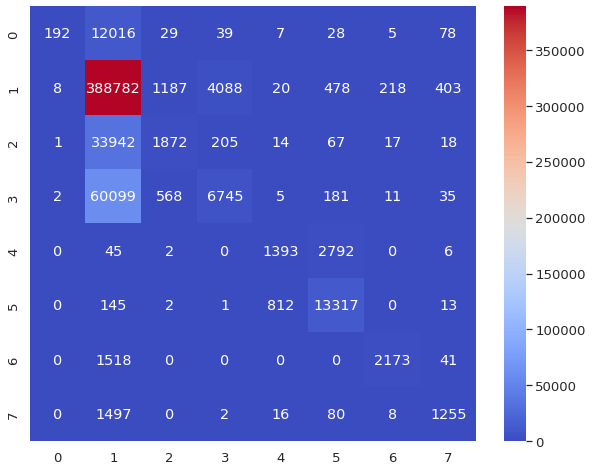

In [ ]:
sns.heatmap(conf_mat, annot=True, cmap='coolwarm', fmt='g')

## Target Encoding feature engineering

In [ ]:
start_time = time.time()
mi_scores = mutual_info_classif(x_train, y_train)
print(f'time-taken: {time.time()-start_time : 0.4f} s')

time-taken:  1206.8394 s


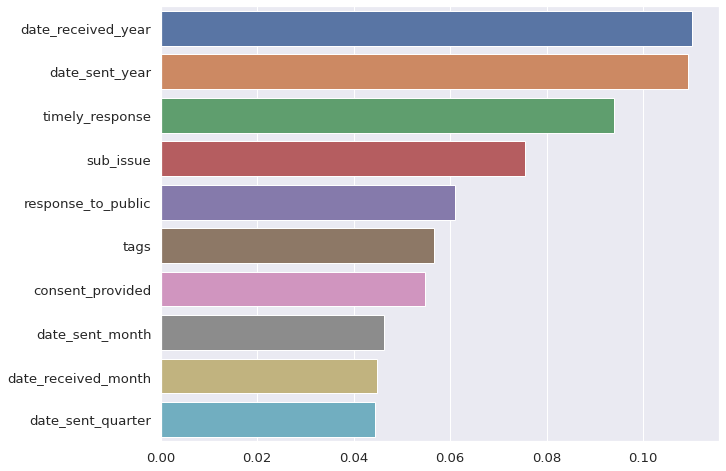

In [ ]:
mi_scores = pd.Series(data=mi_scores, index=x_train.columns.to_list())
mi_scores.sort_values(ascending=False, inplace=True)
k = 10
sns.barplot(x=mi_scores.head(k).values, y=mi_scores.head(k).index)

In [ ]:
cols = ['date_received_year', 'timely_response', 'sub_issue']
for col in cols:
    print(x_train[col].value_counts())

2015    135302
2016    132494
2014    122288
2013     86655
2012     57741
2011      1998
Name: date_received_year, dtype: int64
1    522208
0     14270
Name: timely_response, dtype: int64
-1    320490
 3    107693
 5     26147
 0     25231
 4     21398
 6     13779
 1     11336
 2     10404
Name: sub_issue, dtype: int64


In [ ]:
# df_train = pd.concat([x_train, y_train], axis=1)
# df_train.groupby(cols)[target].apply(len).head(60)

In [ ]:
if not os.path.exists(consumer_complaints_path+'x_train_after_target_encoding.csv'):
    df_train = pd.concat([x_train, y_train], axis=1)
    df_target_mean = df_train.groupby(cols)[target].apply(lambda x: x.mean()).to_frame().reset_index()
    df_target_mean.rename(columns={target : target+'_mean'}, inplace=True)
    df_target_count_percent = df_train.groupby(cols)[target].apply(lambda x: len(x)*100/df_train.shape[0]).to_frame().reset_index()
    df_target_count_percent.rename(columns={target : target+'_count_percent'}, inplace=True)

    x_train = pd.merge(x_train, df_target_mean, how='left', left_on=cols, right_on=cols)
    x_test = pd.merge(x_test, df_target_mean, how='left', left_on=cols, right_on=cols)
    x_train = pd.merge(x_train, df_target_count_percent, how='left', left_on=cols, right_on=cols)
    x_test = pd.merge(x_test, df_target_count_percent, how='left', left_on=cols, right_on=cols)

In [ ]:
if not os.path.exists(consumer_complaints_path+'x_train_after_target_encoding.csv'):
    x_train.to_csv(consumer_complaints_path+'x_train_after_target_encoding.csv')
    y_train.to_csv(consumer_complaints_path+'y_train_after_target_encoding.csv')
    x_test.to_csv(consumer_complaints_path+'x_test_after_target_encoding.csv')
    y_test.to_csv(consumer_complaints_path+'y_test_after_target_encoding.csv')

In [44]:
colab_drive_path = '/content/drive/MyDrive/'
consumer_complaints_path = colab_drive_path+'Colab Notebooks/ml_project/consumer_complaints/'
x_train = pd.read_csv(consumer_complaints_path+'x_train_after_target_encoding.csv', index_col=0)
y_train = pd.read_csv(consumer_complaints_path+'y_train_after_target_encoding.csv', index_col=0)
x_test = pd.read_csv(consumer_complaints_path+'x_test_after_target_encoding.csv', index_col=0)
y_test = pd.read_csv(consumer_complaints_path+'y_test_after_target_encoding.csv', index_col=0)

In [45]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((536478, 120), (536478, 1), (134120, 120), (134120, 1))

### f1_macro score using lightgbm after target encoding

In [ ]:
## after feature engineering
start_time = time.time()
lgb = lightgbm.LGBMClassifier()
scores = cross_val_score(lgb, x_train, y_train, cv=5, scoring="f1_macro")
print(scores.mean())
print(f'time-taken: {time.time()-start_time: 0.4f} s')

0.43012237429017064
time-taken:  252.4815 s


In [ ]:
start_time = time.time()
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_train)
conf_mat = confusion_matrix(y_train, y_pred)
conf_mat = pd.DataFrame(conf_mat, index=encoded_labels, columns=encoded_labels)
print(f'time-taken: {time.time()-start_time:.4f} s')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

time-taken: 75.5951 s


In [ ]:
start_time = time.time()
lgb = lightgbm.LGBMClassifier()
lgb.fit(x_train, y_train)
y_test_pred = lgb.predict(x_test)
f1 = f1_score(y_test, y_test_pred, average='macro')
print(f1)
print(f'time-taken: {time.time()-start_time: 0.4f} s')

0.4332445095038009
time-taken:  64.2628 s


In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.01      0.02      3098
           1       0.78      0.98      0.87     98797
           2       0.50      0.06      0.10      9034
           3       0.60      0.11      0.19     16911
           4       0.51      0.27      0.36      1060
           5       0.77      0.91      0.84      3573
           6       0.85      0.55      0.66       933
           7       0.53      0.36      0.43       714

    accuracy                           0.77    134120
   macro avg       0.66      0.41      0.43    134120
weighted avg       0.74      0.77      0.70    134120



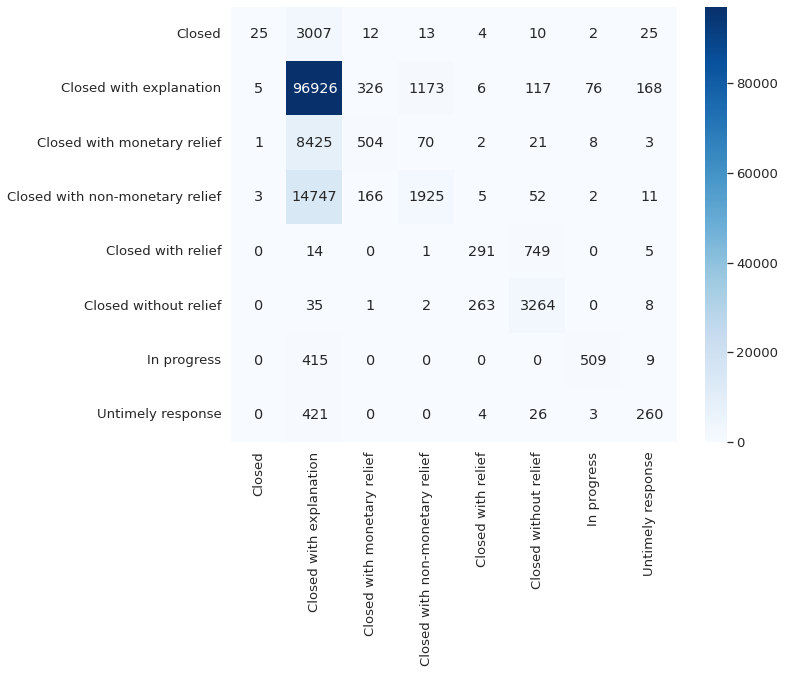

In [ ]:
conf_mat = confusion_matrix(y_test, y_test_pred) 
conf_mat = pd.DataFrame(conf_mat, index=encoded_labels, columns=encoded_labels)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')

## Other Functions

In [47]:
def get_ann_model():
    model = Sequential([
    Dense(128, activation='relu', input_shape=(120,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_value_counts(y):
    y_classes, y_counts = np.unique(y, return_counts=True)
    return {key:val for (key, val) in zip(y_classes, y_counts)}

def get_sns_heatmap(conf_mat, name, balance_algo, f1, encoded_labels=encoded_labels):
    heat_dir = consumer_complaints_path+'heat_plots/'
    if not os.path.isdir(heat_dir):
        os.mkdir(heat_dir)
    conf_mat = pd.DataFrame(conf_mat, index=encoded_labels, columns=encoded_labels)
    heat_plot = sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
    fig = heat_plot.get_figure()
    fig.suptitle(f'f1-macro: {f1: 0.3f}')
    fig.savefig(heat_dir+name+'_'+balance_algo+'.png')
    return heat_plot

def model_name(model):
    return model.__class__.__name__

def get_balance_algo(get_func):
    if get_func == get_f1_score:
        return 'baseline'
    elif get_func == get_f1_confusion_mat_SMOTE:
        return 'SMOTE'
    elif get_func == get_f1_confusion_mat_custom_SMOTETomek:
        return 'custom_SMOTETomek'
    elif get_func == get_f1_confusion_mat_hyperparameter_class_wt:
        return 'class_weight'
    else:
        raise KeyError(f'{get_func} does not exist')

def model_f1_conf_mat(model, x_test=x_test, y_test=y_test):
    if model_name(model) != 'Sequential':
        y_test_pred = model.predict(x_test)
    else:
        y_test_pred = np.argmax(model.predict(x_test), axis=1)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    conf_mat = confusion_matrix(y_test, y_test_pred)
    return f1, conf_mat

## create df_result to save results     
rows - different models <- lightgbm, xgboost, SVC, ANN, KNN, BalancedRandomForrest     
columns - 'baseline', 'SMOTE', 'custom_SMOTETomek', 'class_weight'

In [48]:
models = [lightgbm.LGBMClassifier(), xgboost.XGBClassifier(eval_metric='mlogloss'), SVC(), get_ann_model(), KNeighborsClassifier()]
index = [model_name(model) for model in models]
columns = ['baseline', 'SMOTE', 'custom_SMOTETomek', 'class_weight']

In [49]:
file_result = consumer_complaints_path+'df_result.csv'
if not os.path.exists(file_result):
    nrows = len(index)
    ncols = len(columns)
    data = [['NA']*ncols]*nrows
    df_result = pd.DataFrame(data=data, index=index, columns=columns)
    df_result.to_csv(file_result)

In [50]:
file_train_time = consumer_complaints_path + 'df_train_time.csv'
if not os.path.exists(file_train_time):
    nrows = len(index)
    ncols = len(columns)
    data = [['NA']*ncols]*nrows
    df_time = pd.DataFrame(data=data, index=index, columns=columns)
    df_time.to_csv(file_train_time)

In [51]:
def get_write_result(model, get_func):
    name = model_name(model)
    balance_algo = get_balance_algo(get_func)
    start_time = time.time()
    print(name)
    f1, conf_mat = get_func(model)
    train_time = (time.time()-start_time)/60
    print(f'train-time: {train_time : 0.2f} min')
    print('f1_macro:', f1)
    get_sns_heatmap(conf_mat)
    plt.show() # added to plot each sns plot separately if called upon multiple models
    df_result.loc[name, balance_algo] = f1
    df_result.to_csv(file_result)
    df_time.loc[name, balance_algo] = train_time
    df_time.to_csv(file_result)

In [53]:
df_result

,baseline,SMOTE,custom_SMOTETomek,class_weight
LGBMClassifier,NA,NA,NA,NA
XGBClassifier,NA,NA,NA,NA
SVC,NA,NA,NA,NA
Sequential,NA,NA,NA,NA
KNeighborsClassifier,NA,NA,NA,NA


In [54]:
df_time

,baseline,SMOTE,custom_SMOTETomek,class_weight
LGBMClassifier,NA,NA,NA,NA
XGBClassifier,NA,NA,NA,NA
SVC,NA,NA,NA,NA
Sequential,NA,NA,NA,NA
KNeighborsClassifier,NA,NA,NA,NA


## 1. F1 score without using over-sampling SMOTE (baseline)

In [55]:
def get_f1_score(model = lightgbm.LGBMClassifier(), x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    if model_name(model) != 'Sequential':
        model.fit(x_train, y_train)
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-5, patience=5)
        model.fit(x_train, y_train, validation_split=0.3, epochs=80, 
                  callbacks=[early_stopping, TqdmCallback(verbose=0)], verbose=0)
    return model_f1_conf_mat(model)

In [ ]:
for model in models:
    get_write_result(model, get_f1_score)

LGBMClassifier
train-time:  0.95 min
f1_macro: 0.4332445095038009
test-time:  1.02 min
XGBClassifier
train-time:  17.68 min
f1_macro: 0.3191974569298066
test-time:  17.75 min
SVC


LGBMClassifier
f1_macro: 0.4332445095038009


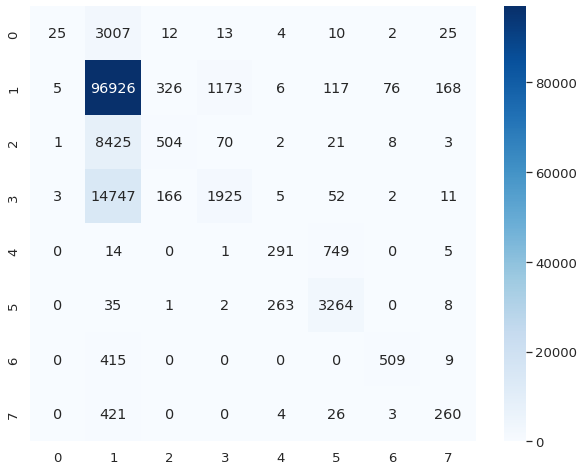

In [ ]:
model = lightgbm.LGBMClassifier()
get_write_result(model, get_f1_score)

XGBClassifier
f1_macro: 0.3191974569298066


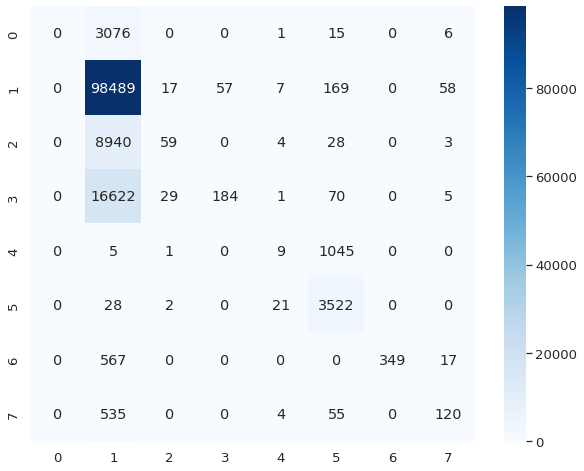

In [ ]:
model = xgboost.XGBClassifier()
get_write_result(model, get_f1_score)

In [ ]:
df_result

,baseline,SMOTE,custom_SMOTETomek,class_weight
LGBMClassifier,0.433,NA,NA,NA
XGBClassifier,0.319,NA,NA,NA
SVC,NA,NA,NA,NA
Sequential,NA,NA,NA,NA
KNeighborsClassifier,NA,NA,NA,NA
BalancedRandomForestClassifier,NA,NA,NA,NA


## 2. F1 score using over-sampling SMOTE

In [ ]:
def get_f1_confusion_mat_SMOTE(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    smt = over_sampling.SMOTE(random_state=7)
    X_smt, y_smt = smt.fit_resample(x_train, y_train)
    if model_name(model) != 'Sequential':
        model.fit(X_smt, y_smt)
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-5, patience=5)
        model.fit(X_smt, y_smt, validation_split=0.3, epochs=80, 
                  callbacks=[early_stopping, TqdmCallback(verbose=0)], verbose=0)
    return model_f1_conf_mat(model)

In [ ]:
for model in models:
    get_write_result(model, get_f1_confusion_mat_SMOTE)

LGBMClassifier
f1_macro: 0.7751585093669111
XGBClassifier


ValueError: ignored

## 3. F1 score using over-sampling SMOTETomek

In [ ]:
def get_f1_confusion_mat_custom_SMOTETomek(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    sampling_strategy = {0:100000, 1:395185, 2:100000, 3:100000, 4:50000, 5:100000, 6:50000, 7:50000}
    sm = combine.SMOTETomek(sampling_strategy=sampling_strategy, random_state=7)
    X_sm, y_sm = sm.fit_resample(x_train, y_train)
    if model_name(model) != 'Sequential':
        model.fit(X_sm, y_sm)
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-5, patience=5)
        model.fit(X_sm, y_sm, validation_split=0.3, epochs=80, 
                  callbacks=[early_stopping, TqdmCallback(verbose=0)], verbose=0)
    return model_f1_conf_mat(model)

In [ ]:
for model in models:
    get_write_result(model, get_f1_confusion_mat_custom_SMOTETomek)

LGBMClassifier
f1_macro: 0.6917292124272907
XGBClassifier


ValueError: ignored

## 4. F1 score using hyperparameter tuning inside algorithm to handle imbalance

In [ ]:
def get_f1_confusion_mat_hyperparameter_class_wt(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    cls_wts = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
    if model_name(model) != 'Sequential':
        model.fit(x_train, y_train, sample_weight=cls_wts)
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-5, patience=5)
        model.fit(x_train, y_train, sample_weight=cls_wts, validation_split=0.3, epochs=80, callbacks=[early_stopping, TqdmCallback(verbose=0)], verbose=0)
    return model_f1_conf_mat(model)

In [ ]:
for model in models:
    get_write_result(model, get_f1_confusion_mat_hyperparameter_class_wt)

# EDA

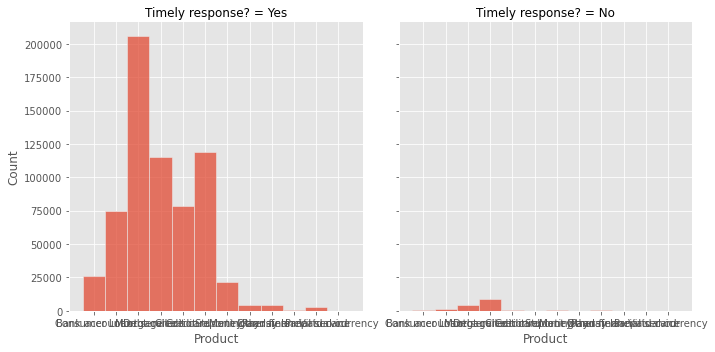

In [ ]:
sns.displot(x='Product', col='Timely response?', data=df)

In [ ]:
df[df['Product']=='Mortgage']['Sub-product'].value_counts()

Other mortgage                            81715
Conventional fixed mortgage               65036
Conventional adjustable mortgage (ARM)    23615
FHA mortgage                              22317
Home equity loan or line of credit        10560
VA mortgage                                4549
Reverse mortgage                           1870
Second mortgage                             662
Name: Sub-product, dtype: int64

In [ ]:
df['Sub-product'].value_counts()

Other mortgage                            81715
Conventional fixed mortgage               65036
Checking account                          53016
Other (i.e. phone, health club, etc.)     37170
I do not know                             26024
Credit card                               25127
Conventional adjustable mortgage (ARM)    23615
FHA mortgage                              22317
Non-federal student loan                  20698
Medical                                   17128
Vehicle loan                              15127
Other bank product/service                14636
Payday loan                               11469
Home equity loan or line of credit        10560
Installment loan                           7078
Savings account                            4711
VA mortgage                                4549
Mortgage                                   4298
Federal student loan servicing             3493
(CD) Certificate of deposit                3158
Auto                                    

In [ ]:
x_train['time_delta'].value_counts()

0      243466
1       61832
2       43508
3       33866
4       32205
        ...  
299         1
298         1
296         1
591         1
511         1
Name: time_delta, Length: 414, dtype: int64